# 1.Reading the dataset

In [ ]:
import pandas as pd


df = pd.read_csv('magic04.data', delimiter=',', header=None)

print(df.head())
print("___________________________________________________\n")
print(df.info())
print("___________________________________________________\n")
print(df.describe())
print("___________________________________________________\n")
print(df.isnull().sum())



         0         1       2       3       4         5        6        7   \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110  -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238  -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580 -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633  -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525  21.8393   

        8         9  10  
0  40.0920   81.8828  g  
1   6.3609  205.2610  g  
2  76.9600  256.7880  g  
3  10.4490  116.7370  g  
4   4.6480  356.4620  g  
___________________________________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       19020 non-null  float64
 1   1       19020 non-null  float64
 2   2       19020 non-null  float64
 3   3       19020 non-null  float

# 2.Balancing the dataset

In [11]:
gamma_df = df[df.iloc[:, 10] == 'g']  # Select gamma events
hadron_df = df[df.iloc[:, 10] == 'h']  # Select hadron events

# Randomly sample 6688 gamma events to match the hadron count
gamma_sampled = gamma_df.sample(n=len(hadron_df), random_state=42)

# Combine the balanced dataset
balanced_df = pd.concat([gamma_sampled, hadron_df])

# Shuffle the dataset to mix classes
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(balanced_df.iloc[:, 10].value_counts())  



10
h    6688
g    6688
Name: count, dtype: int64


# 3.Splitting the dataset

In [16]:

from sklearn.model_selection import train_test_split

# Separate features (X) and labels (y)
X = balanced_df.iloc[:, :-1]  # First 10 columns (features)
y = balanced_df.iloc[:, -1]   # Last column (labels)

# First split: 70% Training, 30% Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Temp set size (Validation + Test):", X_temp.shape[0])

# Second split: 15% Validation, 15% Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])



Training set size: 9363
Temp set size (Validation + Test): 4013
Validation set size: 2006
Test set size: 2007


# 4.Normalization

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



# 5. Apply K_NN

K=1: Validation Accuracy = 0.7976
K=3: Validation Accuracy = 0.8121
K=5: Validation Accuracy = 0.8170
K=7: Validation Accuracy = 0.8180
K=9: Validation Accuracy = 0.8161
K=11: Validation Accuracy = 0.8220
K=13: Validation Accuracy = 0.8156
K=15: Validation Accuracy = 0.8156

Best k found: 11 with Accuracy = 0.8220


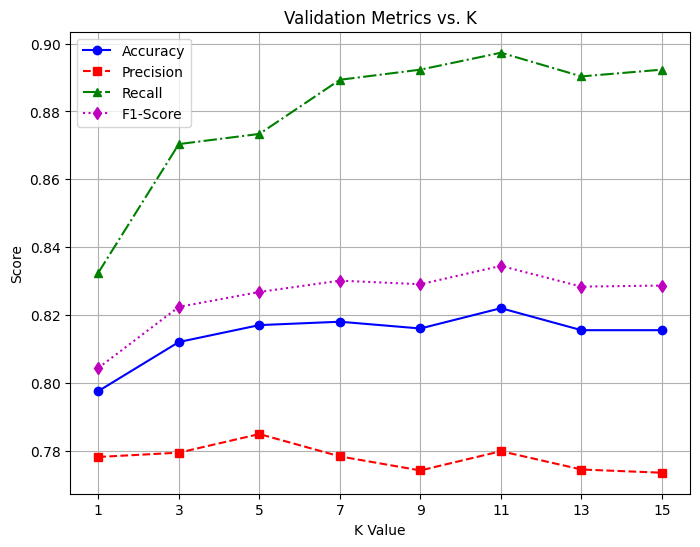


 Final Model Evaluation on Test Set:
 Accuracy: 0.8266
 Precision: 0.7832
 Recall: 0.9034
 F1-Score: 0.8390

Confusion Matrix:
[[907  97]
 [251 752]]


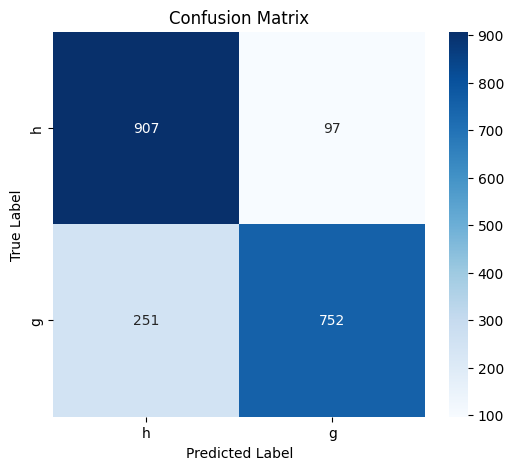

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define a list of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

best_k = None
best_score = 0

# Lists to store different evaluation metrics
validation_accuracies = []
validation_precisions = []
validation_recalls = []
validation_f1_scores = []

# Loop over different values of k
for k in k_values:
    # Initialize and train K-NN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Predict on the validation set
    y_val_pred = knn.predict(X_val_scaled)
    
    # Compute metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, pos_label="g")
    recall = recall_score(y_val, y_val_pred, pos_label="g")
    f1 = f1_score(y_val, y_val_pred, pos_label="g")

    # Store metrics for plotting
    validation_accuracies.append(accuracy)
    validation_precisions.append(precision)
    validation_recalls.append(recall)
    validation_f1_scores.append(f1)

    print(f"K={k}: Validation Accuracy = {accuracy:.4f}")

    # Track the best k based on accuracy
    if accuracy > best_score:
        best_score = accuracy
        best_k = k

print(f"\nBest k found: {best_k} with Accuracy = {best_score:.4f}")

# Plot Validation Accuracy, Precision, Recall, and F1-Score vs. k
plt.figure(figsize=(8, 6))
plt.plot(k_values, validation_accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.plot(k_values, validation_precisions, marker='s', linestyle='--', color='r', label="Precision")
plt.plot(k_values, validation_recalls, marker='^', linestyle='-.', color='g', label="Recall")
plt.plot(k_values, validation_f1_scores, marker='d', linestyle=':', color='m', label="F1-Score")

plt.xlabel("K Value")
plt.ylabel("Score")
plt.title("Validation Metrics vs. K")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

# Train the final model with the best k
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_test_pred = final_knn.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label="g")
recall = recall_score(y_test, y_test_pred, pos_label="g")
f1 = f1_score(y_test, y_test_pred, pos_label="g")
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n Final Model Evaluation on Test Set:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["h", "g"], yticklabels=["h", "g"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


comments: @k=11 has the best accuracy of 0.8220 , at bigger k (13,15) the accuracy decreases due to over smoothing as the model underfits....
the matrix indicates that at the best accuracy there as still a noticable number of bad predictions.